<a href="https://colab.research.google.com/github/kyleplhm/cloud_computing/blob/main/Big_Mac_Index_Happiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Relationship Between World Happiness and the BigMac Index
Kyle Pelham (kpelham@calpoly.edu)

Shayan Golshan (ssgolsha@calpoly.edu)

**February 2023**


## Introduction

In this notebook, we are exploring the correlation of a country's Big Mac Index to its overall happiness.

The Big Mac index is an economic measurement of consumer purchasing power by comparing the price of a single Big Mac in other countries to the cost of a Big Mac in the United States. The Purchasing Power Parity(PPP) theory suggests that a product or good will cost the same across all countries after converting to their local currency. However, this is an ideal situation and in reality there are currencies that are overvalued(they pay more in USD) and undervalued(they pay less in USD). The Big Mac Index is fun way to get an approximate measurement of global buying power since the Big Mac is a common item that is sold across over 150+ countries and is essentially made the same way.

**Hypothesis:** Our hypothesis is that there is a postitive correlation between a Country's Big Mac Index and thier overall happiness. In other words, based on the Big Mac Index, countries with higher valued currencies are happier on average than those with lower valued currencies.

**The data used to complete this analysis can be found below:**

Big Max Index Data (using adjusted index): [https://github.com/TheEconomist/big-mac-data](https://github.com/TheEconomist/big-mac-data)

World Happiness Report: [https://worldhappiness.report/archive/](https://worldhappiness.report/archive/)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in the Data

To perform this analysis, Big Mac Data must be joined onto the Happiness data. First, the happiness data for each year needs to be merged together, however,  the countries listed in each year's happiness report slightly vary from year to year. To fix this, each year's data is filtered on a common list of countries across all eight years and then is merged by stacking the rows for each.

In [ ]:
# Read in World Happiness data from Google Drive Folder
happy2015 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2015.csv')
happy2016 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2016.csv')
happy2017 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2017.csv')
happy2018 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2018.csv')
happy2019 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2019.csv')
happy2020 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2020.csv')
happy2021 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2021.csv')
happy2022 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2022.csv')


In [ ]:
# Create Year column for each dataset
happy2015['Year'] = '2015'
happy2016['Year'] = '2016'
happy2017['Year'] = '2017'
happy2018['Year'] = '2018'
happy2019['Year'] = '2019'
happy2020['Year'] = '2020'
happy2021['Year'] = '2021'
happy2022['Year'] = '2022'

# Create a list of each df for later iteration
happiness_data = [happy2015,happy2016,happy2017,happy2018,happy2019,happy2020,happy2021,happy2022]

In [ ]:
# Required columns for subsetting
columns_to_keep = ['Country', 'Happiness Score', 'Year']

# Create an empty list to store the extracted dataframes
happiness_data_reduced = []

# loop over each dataframe in happiness_data
for df in happiness_data:
    # extract the desired columns and assign it back to the same dataframe
    df = df[columns_to_keep]
    # append the modified dataframe to the happiness_data_reduced list
    happiness_data_reduced.append(df)

In [ ]:
# Get the set of countries in each dataframe
country_sets = [set(df['Country']) for df in happiness_data_reduced]

# Find the intersection of all the sets
common_countries = set.intersection(*country_sets)

# Filter each dataframe to include only the common countries
filtered_dfs = [df[df['Country'].isin(common_countries)] for df in happiness_data_reduced]

# Bind rows of each happiness dataset together
final_happiness = pd.concat(filtered_dfs)
final_happiness['Happiness Score'] = pd.to_numeric(final_happiness['Happiness Score'])
final_happiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 145
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          936 non-null    object 
 1   Happiness Score  936 non-null    float64
 2   Year             936 non-null    object 
dtypes: float64(1), object(2)
memory usage: 29.2+ KB


The Big Mac Index data is merged with the happiness data by performing an inner join on Country and Year. All data before 2015 is dropped to match up with the happiness data. Uncommon countries were looked at externally for misspellings but there were none.

In [68]:
bigmac = pd.read_csv('/content/drive/MyDrive/BigMac Data/big-mac-adjusted-index.csv')

# separate the date column into year and month and filter where year is greater than 2015. 
bigmac["year"] = bigmac["date"].str.split("-").str.get(0)
bigmac["month"] = bigmac["date"].str.split("-").str.get(1)
bigmac["Country"] = bigmac["name"]
bigmac = bigmac[bigmac["year"]>="2015"]

# Drop the date column
bigmac.drop("date", axis=1, inplace=True)
bigmac.drop("month", axis=1, inplace=True)
bigmac.drop("name", axis=1, inplace=True)

# concatenate name and year in a new column
bigmac["Country_Year"] = bigmac["Country"] + " " + bigmac["year"]
#print(bigmac)

# convert the year column to string
final_happiness["Year"] = final_happiness["Year"].astype(str)
final_happiness["Country_Year"] = final_happiness["Country"] + " " + final_happiness["Year"]

# Join the datasets on key column
merged = pd.merge(bigmac, final_happiness, on='Country_Year', how='inner', suffixes=('_1', '_2'))
#print(merged)

# Select rows needed for analysis
merged2 = merged[['USD', 'Country_1','Happiness Score','Year']]

# Rename USD to proper name
merged2 = merged2.rename({'USD': 'BigMacIndex(USD)'}, axis=1)




<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BigMacIndex(USD)  561 non-null    float64
 1   Country_1         561 non-null    object 
 2   Happiness Score   561 non-null    float64
 3   Year              561 non-null    object 
dtypes: float64(2), object(2)
memory usage: 21.9+ KB


# Analyzing the Data

<AxesSubplot:title={'center':'Happiness Score by Year'}, xlabel='Year', ylabel='Happiness Score'>

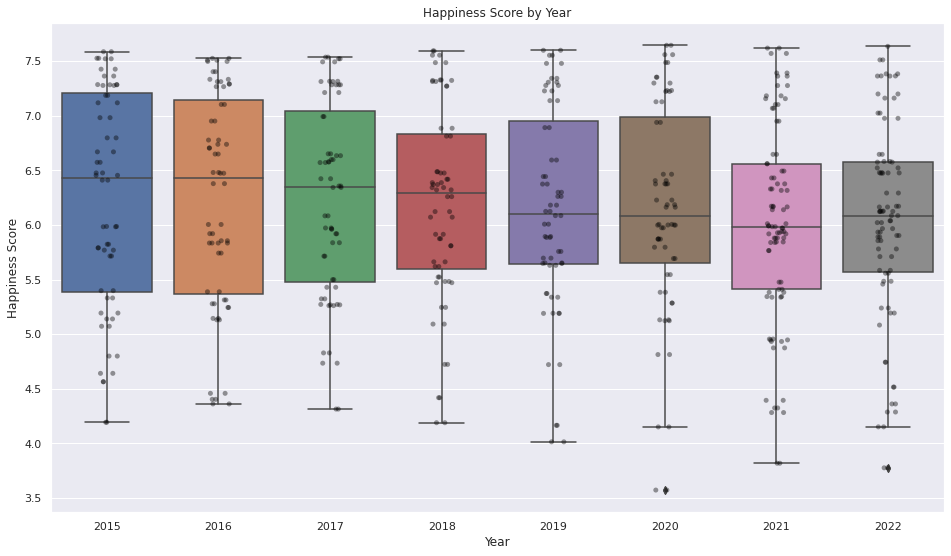

In [ ]:
# Box plot for Happiness Score by year. Each observation is one country
sns.set(rc={'figure.figsize':(16,9)})
sns.boxplot(x="Year", y="Happiness Score", data=merged2).set(title='Happiness Score by Year')
sns.stripplot(x="Year", y="Happiness Score", color = 'black', alpha = 0.4, data=merged2, jitter = True)

<AxesSubplot:title={'center':'Big Mac Index by Year'}, xlabel='Year', ylabel='BigMacIndex(USD)'>

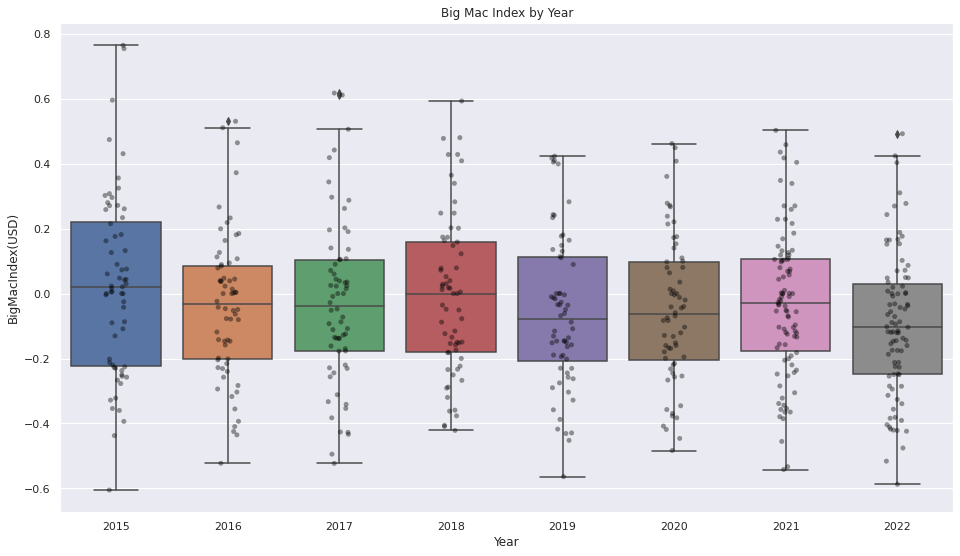

In [ ]:
# Box plot for Big Mac Index by year. Each observation is one country
sns.set(rc={'figure.figsize':(16,9)})
sns.boxplot(x="Year", y="BigMacIndex(USD)", data=merged2).set(title='Big Mac Index by Year')
sns.stripplot(x="Year", y="BigMacIndex(USD)", color = 'black', alpha = 0.4, data=merged2, jitter = True)

In [ ]:
# Group by country and calculate mean happiness score
happiness_by_country = merged2.groupby('Country_1').mean()

# Looking at the happiest countries on average
happiness_by_country.sort_values(ascending = False, by = 'Happiness Score').head()

,BigMacIndex(USD),Happiness Score
Country_1,,
Denmark,0.035211,7.575147
Switzerland,0.469526,7.524987
Norway,0.254988,7.493750
Sweden,0.344193,7.337062
New Zealand,0.035803,7.292700


In [ ]:
# Looking at the least happy countries on average
happiness_by_country.sort_values(ascending = True, by = 'Happiness Score').head()

,BigMacIndex(USD),Happiness Score
Country_1,,
India,-0.212251,4.082287
Jordan,-0.123663,4.273500
Egypt,-0.275704,4.324800
Sri Lanka,0.077625,4.343500
South Africa,-0.352659,4.792512


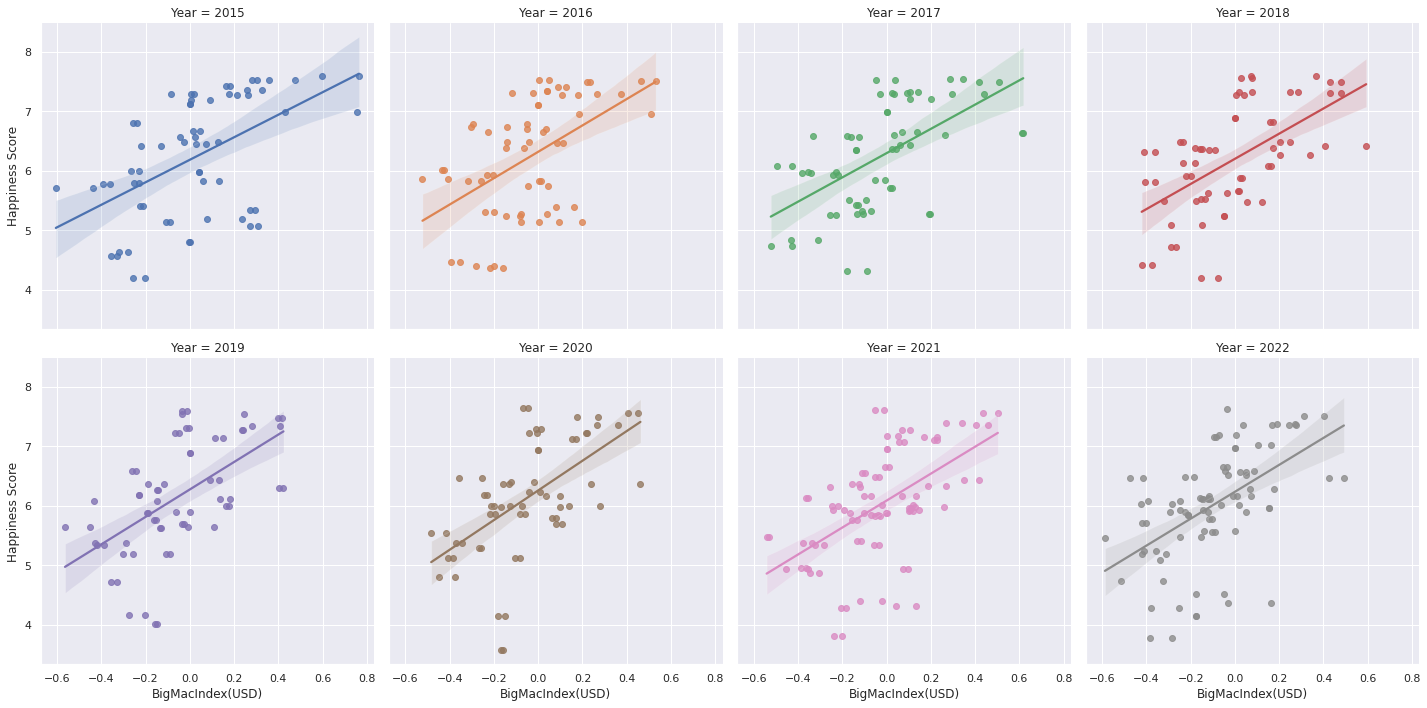

In [ ]:
# Regplot for Happiness Score and Bigmac Index faceted by year
sns.set(style="darkgrid")
g = sns.FacetGrid(merged2, col="Year", col_wrap=4, height=5, aspect=1, hue='Year')
g.map(sns.regplot, "BigMacIndex(USD)", "Happiness Score")

In [ ]:
# find r coeificient and p value
r, p = pearsonr(merged2['BigMacIndex(USD)'], merged2['Happiness Score'])

print(r,p)

0.5538558179737851 2.0442524920265488e-46


# Conclusion

Based on our visual and statistical analysis, we conclude that there is a moderate positive linear relationship between the Big Mac Index and overall happiness for a given country.

In [ ]:
#Fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

#colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

#for i, year in enumerate(range(2015, 2023)):
    #row = i // 4
    #col = i % 4
    #data = merged2[merged2['Year'] == year]
    #axs[row, col].scatter(data['BigMacIndex(USD)'], data['Happiness Score'], color = colors[i])
    #axs[row, col].set_xlabel('BigMac Index USD')
    #axs[row, col].set_ylabel('Happiness Score')
    #axs[row, col].set_title(year)

#plt.tight_layout()

#plt.show()